In [13]:
import numpy as np
import qiskit
import gym
import qiskit.circuit.library as circuits

In [14]:
env = gym.make('FrozenLake-v1', is_slippery=False)

In [15]:
num_episodes = 1000
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1

In [16]:
num_qubits = 4  # Adjust this based on your specific VQC design
num_actions = 4  # Number of possible actions in the environment

In [17]:
num_states = env.observation_space.n
q_table = np.zeros((num_states, num_actions))

In [18]:
#backend = qiskit.Aer.get_backend('qasm_simulator')
backend = qiskit.Aer.get_backend('aer_simulator_statevector')

In [19]:
def build_vqc_circuit(state, start):
    #qc = qiskit.QuantumCircuit(num_qubits)
    # Add variational layers, gates, and measurements as needed
    ref = qiskit.QuantumCircuit(4)
    for i in range(4):
        if start & (1 << i):  # Check if the i-th bit is 1
            ref.x(i)
    ref.barrier()
    qc = circuits.TwoLocal(4, "rx", "cz", entanglement = "linear", reps = 1, insert_barriers = True)
    qc = ref.compose(qc)

    qc.assign_parameters(state)
    qc.measure_all()
    return qc

In [20]:
state = env.reset()
print(state)
print(type(state))

0
<class 'int'>


In [21]:
#from qiskit.circuit.library import TwoLocal

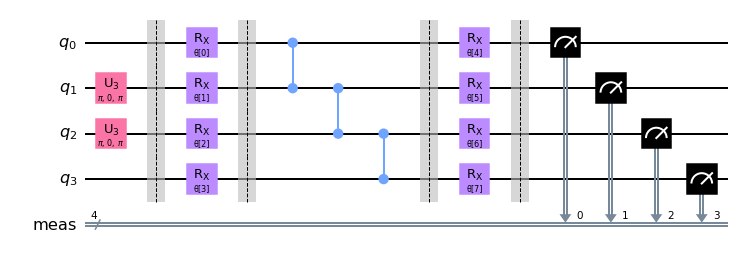

In [22]:
#qc = circuits.TwoLocal(4, "rx", "cz", entanglement = "linear", reps = 2, insert_barriers = True)

#qc.decompose().draw("mpl")
initial_params = np.random.rand(num_qubits * 2)

qc = build_vqc_circuit(initial_params, 6)

qc.decompose().draw("mpl")


In [23]:
def objective_function(params):
    # Build the VQC circuit with updated parameters
    quantum_circuit = build_vqc_circuit(params, 0)

    # Simulate the circuit to obtain measurement outcomes
    transpiled_circuit = qiskit.transpile(quantum_circuit, backend)
    qobj = qiskit.assemble(transpiled_circuit, shots = 100)
    job = backend.run(qobj)
    #result = qiskit.run(transpiled_circuit, backend).result()
    result = job.result().get_counts()
    counts = np.array(list(result.values()))

    # Map measurement outcomes to actions (customize as needed)
    action = int(max(counts, key=counts.get))  # Choose the action with the highest count

    # Initialize variables
    state = env.reset()
    total_reward = 0

    # Q-learning loop
    for _ in range(num_episodes):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = action  # Exploit based on VQC's recommendation

        # Take the selected action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update the Q-table using Q-learning update rule
        q_table[state, action] = (1 - learning_rate) * q_table[state, action] + \
            learning_rate * (reward + discount_factor * np.max(q_table[next_state, :]))

        total_reward += reward
        state = next_state

        if done:
            state = env.reset()  # Reset the environment when an episode is done

    return -total_reward

In [24]:
from scipy.optimize import minimize

initial_params = np.random.rand(num_qubits * 2)
#initial_params = 4

#objective_function(initial_params)

# Use a classical optimizer to find the best parameters
result = minimize(objective_function, initial_params, method='COBYLA')
best_params = result.x

# After optimization, best_params contain the optimized parameter values
#print("Optimal parameters:", best_params)

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])])]'